In [146]:
import string, re, json, pickle, warnings, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from data_preparation import take_a_shower, clean_content_aravec
from utils import *

%matplotlib inline
warnings.filterwarnings('ignore')

In [147]:
np.random.seed(42)

In [148]:
data = pd.read_csv('./data/offensive_dataset.csv', encoding="utf-16")
data.head()

,Comment,is_off
0,شوف حد ين*** أنت و إيران.,1
1,شوف تيفي قوداتها مع الجن غي بلاتي يجي من مكة,0
2,عجب يتفاوظون على شعوب عربية وعليهم وهىلا تعلم,0
3,ههههههه هاد شوف تيفي اللي حطت عليه مشا فيها,0
4,الرزق يأتي من حيث لا تدري 🙌🏻❤️,0


<AxesSubplot:xlabel='is_off', ylabel='count'>

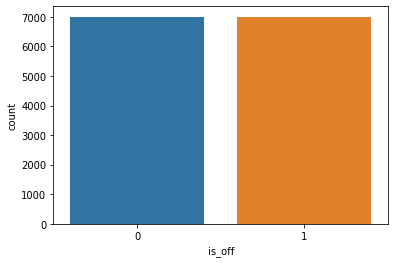

In [149]:
sns.countplot(x='is_off', data=data)

In [150]:
data.Comment = data.Comment.apply(take_a_shower)
data.shape

(14000, 2)

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  14000 non-null  object
 1   is_off   14000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 218.9+ KB


In [152]:
data.head()

,Comment,is_off
0,شوف حد ايران,1
1,شوف تيفي قوداتها الجن غي بلاتي يجي مكه,0
2,عجب يتفاوظون شعوب عربيه وعليهم وهيلا تعلم,0
3,هه هاد شوف تيفي اللي حطت مشا,0
4,الرزق ياتي تدري 🙌🏻❤️,0


# AraVec Embedding

In [237]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelEncoder
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import Callback
from keras.utils import np_utils
from keras.regularizers import l1,l2
import gensim

In [154]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100 #176 # based on our inputs; TODO: remove outliers? dynamically calculate!
EMBEDDING_DIM = 100 # w2v, fastText; GloVe=50

In [ ]:
# path = './bin/aravec/tweets_sg_100'
path = './bin/aravec/full_grams_sg_300_twitter.mdl'
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(path)

In [316]:
print(MAX_FEATURES)
print(EMBED_SIZE)

20000
300


In [298]:
# load data
x = data.Comment.values
y = data.is_off.values
MAX_TEXT_LENGTH = get_max_length(x)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Dataset splited.')
CLASSES_LIST = np.unique(y)
print('Label categories: ' + str(CLASSES_LIST))
print("Max Length: " + str(MAX_TEXT_LENGTH))

Dataset splited.
Label categories: [0 1]
Max Length: 461


In [299]:
# Sequence length
print("Original sequence length : "+str(MAX_TEXT_LENGTH))

# CHANGE MAX LENGTH (timesteps)
MAX_TEXT_LENGTH = 200
MAX_FEATURES = 20000

Original sequence length : 461


In [300]:
x_train, x_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(X_train, X_test, 
                                                                            Y_train, Y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)
print('Found %d unique words.' % len(word_index))
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Converting data to trainable form...
Number of training examples: 11200
Number of testing examples: 2800
Found 44530 unique words.


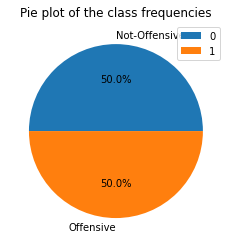

In [301]:
LABELS = ('Not-Offensive', 'Offensive')
tmp = np.concatenate((y_train, y_test))
unique, counts = np.unique(tmp, return_counts=True)
del tmp
plt.figure("Target Pie")
plt.title("Pie plot of the class frequencies")
plt.pie(counts, labels=LABELS, autopct='%1.1f%%')
plt.legend(unique)
# plt.savefig("./img/stats_classes.png")
plt.show();

In [302]:
def get_lstm_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    print("Build LSTM Model ...")

    """
    MAX_FEATURES: 331679
    MAX_TEXT_LENGTH: 100
    =========================
    Training Accuracy: 0.8969
    Training Loss: 0.2534
    =========================
    Testing Accuracy:  0.7900
    Testing Loss:  0.5070
    
    MAX_FEATURES: 20000
    MAX_TEXT_LENGTH: 200
    =========================
    Training Accuracy: 0.9485
    Training Loss: 0.1688
    =========================
    Testing Accuracy:  0.8186
    Testing Loss:  0.6079
    
    MAX_FEATURES: 10000
    MAX_TEXT_LENGTH: 200
    =========================
    Training Accuracy: 0.9145
    Training Loss: 0.2280
    =========================
    Testing Accuracy:  0.8071
    Testing Loss:  0.4580
    """    
    model = Sequential()
    model.add(Input(shape=(max_length,)))
    model.add(Embedding(input_dim=len(word_index)+1, 
                        output_dim=vocab_dim, 
                        trainable=False,
                        weights=[embedding_weights]))
    model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model

In [303]:
print("Parameters Values:")
print("word_index: ")
print(len(word_index))
print("WORD_MODEL: ")
print(WORD_MODEL)
print("EMBED_SIZE: ")
print(EMBED_SIZE)
print("MAX_TEXT_LENGTH: ")
print(MAX_TEXT_LENGTH)
print("MAX_FEATURES:")
print(MAX_FEATURES)

embedding_matrix, words_not_found = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)

Parameters Values:
word_index: 
44530
WORD_MODEL: 
EMBED_SIZE: 
300
MAX_TEXT_LENGTH: 
200
MAX_FEATURES:
20000
Building embedding matrix...
Embedding matrix built.


In [304]:
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 8829


In [206]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['ديرهو' 'صدوراوامرتنفيذ' 'هييهيامقاومه' 'راعيتان' 'وضلالتكم' 'واليهودايش'
 'الزومل' 'بالاديانوالدليل' 'وانظلمو' 'لاحوها']


In [305]:
model = get_lstm_model(embedding_matrix, 
                       word_index, 
                       EMBED_SIZE, 
                       MAX_TEXT_LENGTH, 
                       print_summary=True)

Build LSTM Model ...
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 200, 300)          13359300  
_________________________________________________________________
lstm_30 (LSTM)               (None, 200, 32)           42624     
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 32)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_73 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_74 (Dropout)         (No

In [164]:
def train_fit_predict(model, x_train, x_test, y_train, y_test, batch_size, epochs):
    """
    DOC 
    """
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
    return history, model

In [306]:
history, model = train_fit_predict(model,
                               x_train,
                               x_test,
                               y_train, y_test,
                               batch_size=64, epochs=25)

Epoch 1/25
140/140 [==============================] - 33s 233ms/step - loss: 0.6684 - accuracy: 0.5900 - val_loss: 0.6002 - val_accuracy: 0.6942
Epoch 2/25
140/140 [==============================] - 32s 231ms/step - loss: 0.5653 - accuracy: 0.7253 - val_loss: 0.5164 - val_accuracy: 0.7545
Epoch 3/25
140/140 [==============================] - 31s 221ms/step - loss: 0.5165 - accuracy: 0.7578 - val_loss: 0.4821 - val_accuracy: 0.7790
Epoch 4/25
140/140 [==============================] - 33s 235ms/step - loss: 0.4875 - accuracy: 0.7699 - val_loss: 0.4748 - val_accuracy: 0.7705
Epoch 5/25
140/140 [==============================] - 32s 231ms/step - loss: 0.4656 - accuracy: 0.7789 - val_loss: 0.4699 - val_accuracy: 0.7719
Epoch 6/25
140/140 [==============================] - 30s 214ms/step - loss: 0.4498 - accuracy: 0.7952 - val_loss: 0.4611 - val_accuracy: 0.7812
Epoch 7/25
140/140 [==============================] - 32s 226ms/step - loss: 0.4355 - accuracy: 0.7962 - val_loss: 0.4562 - val_ac

In [307]:
loss, accuracy = model.evaluate(x_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss_val, accuracy_val = model.evaluate(x_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))
print("Testing Loss:  {:.4f}".format(loss_val))

350/350 [==============================] - 16s 46ms/step - loss: 0.2679 - accuracy: 0.8836
Training Accuracy: 0.8836
Training Loss: 0.2679
88/88 [==============================] - 4s 47ms/step - loss: 0.4261 - accuracy: 0.8186
Testing Accuracy:  0.8186
Testing Loss:  0.4261


In [308]:
y_pred = model.predict(x_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred = (y_pred > 0.5)

print(classification_report(y_test, y_pred))

88/88 [==============================] - 4s 46ms/step
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1384
           1       0.87      0.76      0.81      1416

    accuracy                           0.82      2800
   macro avg       0.82      0.82      0.82      2800
weighted avg       0.82      0.82      0.82      2800



In [309]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on test : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on test : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 19
Accuracy on train : 84.97 %
Accuracy on test : 81.92 %
Loss on train : 34.58
Loss on test : 38.94


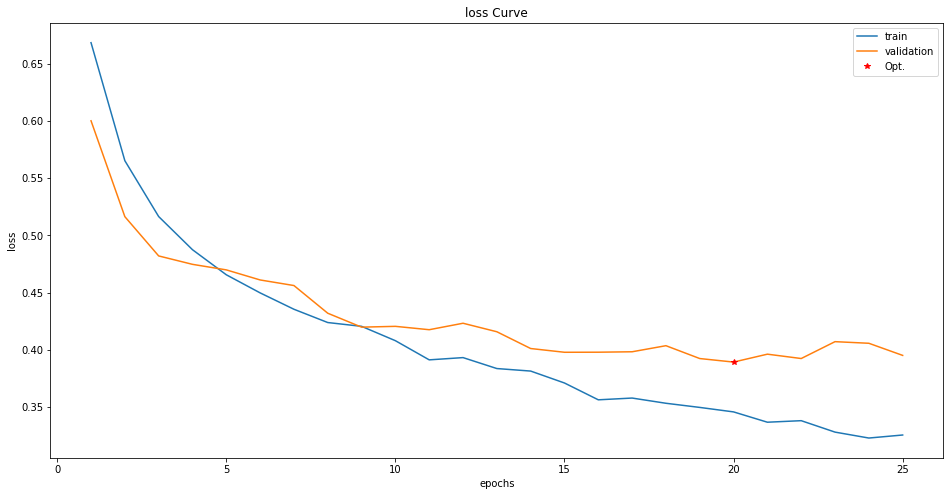

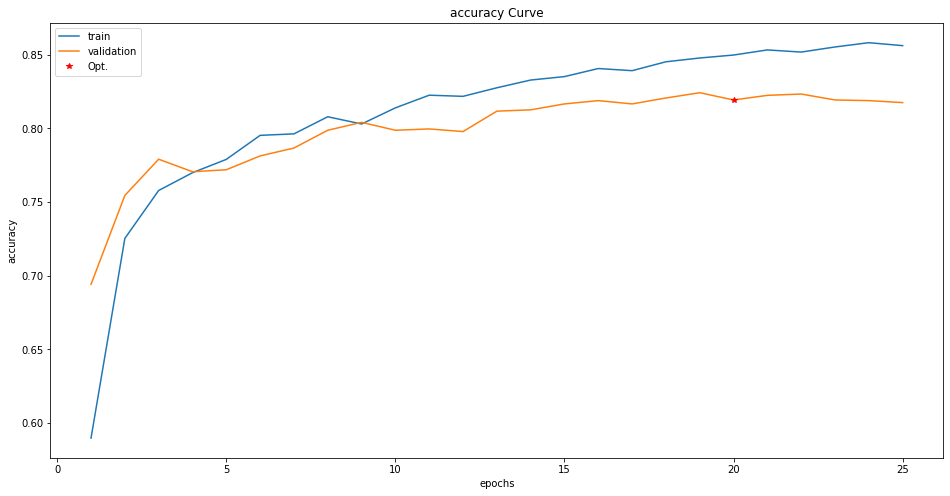

In [310]:
#train loss vs validation loss
show_train_history(history,'loss','val_loss', n)

show_train_history(history,'accuracy','val_accuracy', n)

In [311]:
pred_test = model.predict(x_test, verbose=True)
df_blind = pd.DataFrame({'REAL': y_test, 
                         'PRED': pred_test.reshape(pred_test.shape[0],), 
                         'TEXT': X_test})
df_blind = df_blind.reset_index()[['REAL', 'PRED', 'TEXT']]
df_blind.PRED = df_blind.PRED.round()
error_records = df_blind[df_blind.REAL != df_blind.PRED]

88/88 [==============================] - 4s 46ms/step


In [312]:
print("Number of misclassified reviews: {} out of {}".format(error_records.shape[0], df_blind.shape[0]))
print("Blind Test Accuracy:  {:.4f}".format(accuracy_score(df_blind.REAL, df_blind.PRED)))

Number of misclassified reviews: 508 out of 2800
Blind Test Accuracy:  0.8186


In [185]:
print(len(df_blind[df_blind.REAL != df_blind.PRED]))

'انا شايف انو رغم عدوانيه هالقرار مازلنا مصرين تمجيد امريكا والتركيز ايجابياتها وانسانيه شعبها بينما المفروض نركز فكره انو اكتر <NUM> الاميركان موافقين قرار ترامب الحبواني وهدول ال <NUM> هنن اخطر الارهابيين بالعالم'

In [314]:
df_blind[df_blind.PRED == 0]

,REAL,PRED,TEXT
3,0,0.0,حياه انسان لحظه لاتعود الحياه بعدها قبلها
5,0,0.0,سيري الله يمسخك صبات سحات بغيتي يديها فسوق راس...
6,1,0.0,جبهه النصره تعرف القاعده مربط الجمل
7,0,0.0,اتحدي النظام يفعل اللحظه <NUM> الامام
8,0,0.0,<NUM> <NUM>
...,...,...,...
2791,1,0.0,وبعديين 😔 اثق بشخص انو قلبو عالقضيه وشريف بنفض...
2793,1,0.0,كيانك نتيجه استفتاء لتبارك للاسبانيا فتحها الع...
2794,0,0.0,انا شايف انو رغم عدوانيه هالقرار مازلنا مصرين ...
2796,1,0.0,كيتلوا بحال لفعه الله يعطك دقه جدي طاح ناد


In [315]:
save_model('aravec', 'lstm', round(accuracy_val, 4))

Model Saved Successfully in ./models/aravec/


In [279]:
def save_model(folder, name, acc):
    with open('./models/' + folder + '/' + name + '_acc_' + str(acc) + '.json', 'w') as f:
        f.write(model.to_json())
        f.close()

    model.save_weights('./models/' + folder + '/' + name + '_weights_acc_' + str(acc) + '.h5')

    model.save('./models/' + folder + '/' + name + '_acc_' + str(acc) + '.h5')
    
    print("Model Saved Successfully in ./models/" + folder + "/")

In [44]:
def show_train_history(history,train,validation, n):
    plt.figure(figsize=(16, 8))
    plt.plot(range(1, len(history.history[train])+1), history.history[train], label="train")
    plt.plot(range(1, len(history.history[validation])+1), history.history[validation], label="validation")
    plt.plot(n+1,history.history[validation][n],"r*", label="Opt.")
    plt.legend()
    plt.title(str(train) + " Curve")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.show()